In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)

%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [5]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter = delimeter)
    print('Dimensions:', data.shape)
    print(data[1:6,:])
    return (data)

In [6]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # 获得正负样本的下标(即哪些是正样本，哪些是负样本)
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    if axes == None:
        axes = plt.gca() # if the current axes doesn't exit, the appropriate axes will be created
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);
    # fancybox (legend whether 启用圆边界)

In [7]:
data = loaddata('data1.txt', ',')

Dimensions: (100, 3)
[[30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]
 [45.08327748 56.31637178  0.        ]]


In [8]:
x = np.c_[np.ones((data.shape[0],1)), data[:,0:2]]
y = np.c_[data[:,2]]

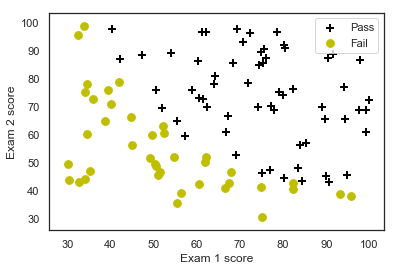

In [9]:
plotData(data,'Exam 1 score', 'Exam 2 score', 'Pass', 'Fail')

In [10]:
#定义sigmoid函数
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

In [11]:
#定义损失函数
def costFunction(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    
    J = -1.0*(1.0/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y))
               
    if np.isnan(J[0]): #若出现nan转换成相应的数值
        return(np.inf)
    return J[0]

In [12]:
#求解梯度
def gradient(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    
    grad =(1.0/m)*X.T.dot(h-y)

    return(grad.flatten())

In [14]:
initial_theta = np.zeros(x.shape[1])
cost = costFunction(initial_theta, x, y)
grad = gradient(initial_theta, x, y)
print('Cost: \n', cost)
print('Grad: \n', grad)

Cost: 
 0.6931471805599452
Grad: 
 [ -0.1        -12.00921659 -11.26284221]


In [16]:
# 最小话损失函数
res = minimize(costFunction, initial_theta, args=(x,y),jac=gradient, options={'maxiter':400})
res

/Users/xiaoyuer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/xiaoyuer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


      fun: 0.2034977015895099
 hess_inv: array([[ 2.85339493e+03, -2.32908823e+01, -2.27416470e+01],
       [-2.32908823e+01,  2.04489131e-01,  1.72969525e-01],
       [-2.27416470e+01,  1.72969525e-01,  1.96170322e-01]])
      jac: array([-2.68557631e-09,  4.36433478e-07, -1.39671758e-06])
  message: 'Optimization terminated successfully.'
     nfev: 34
      nit: 25
     njev: 30
   status: 0
  success: True
        x: array([-25.16131634,   0.2062316 ,   0.20147143])

In [17]:
def predict(theta, X, threshold=0.5):
    p = sigmoid(X.dot(theta.T)) >= threshold
    return(p.astype('int'))

In [18]:
sigmoid(np.array([1, 45, 85]).dot(res.x.T))

0.7762903249331018

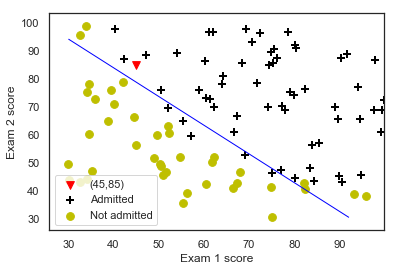

In [23]:
# draw decision boudarying
plt.scatter(45,85,s=60,c='r',marker='v',label='(45,85)')
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')
x1_min, x1_max = x[:,1].min(), x[:,1].max(),
x2_min, x2_max = x[:,2].min(), x[:,1].max(),
xx1,xx2 = np.meshgrid(np.linspace(x1_min, x1_max),np.linspace(x2_min,x2_max))
# .linspace在指定间隔内返回均匀数字
# 。meshgrid返回矩阵
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(res.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');

In [24]:
# 加入正则化的逻辑回归
data2 = loaddata('data2.txt', ',')

Dimensions: (118, 3)
[[-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]]


In [25]:
x = data2[:,0:2]
y = np.c_[data2[:,2]]

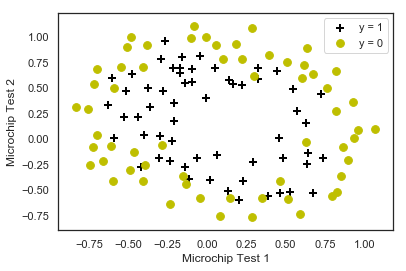

In [26]:
plotData(data2,'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

In [27]:
poly = PolynomialFeatures(6)
# 最高阶6的多项式特征
xx = poly.fit_transform(data2[:,0:2])
xx.shape

(118, 28)

In [40]:
# 定义损失函数
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(xx.dot(theta))
    
    J = -1.0*(1.0/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2.0*m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

In [41]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(xx.dot(theta.reshape(-1,1)))
      
    grad = (1.0/m)*xx.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [42]:
initial_theta = np.zeros(xx.shape[1])
costFunctionReg(initial_theta, 1, xx, y)

0.6931471805599453

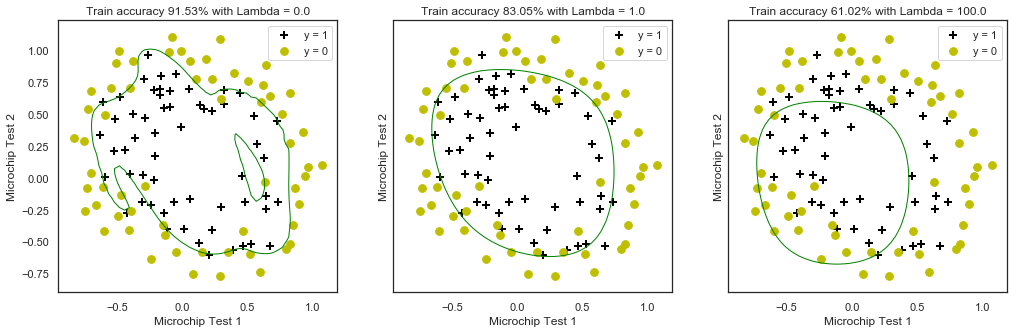

In [44]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# 决策边界，咱们分别来看看正则化系数lambda太大太小分别会出现什么情况
# Lambda = 0 : 就是没有正则化，这样的话，就过拟合咯
# Lambda = 1 : 这才是正确的打开方式
# Lambda = 100 : 卧槽，正则化项太激进，导致基本就没拟合出决策边界

for i, C in enumerate([0.0, 1.0, 100.0]):
    # 最优化 costFunctionReg
    res2 = minimize(costFunctionReg, initial_theta, args=(C, xx, y), jac=gradientReg, options={'maxiter':3000})
    
    # 准确率
    accuracy = 100.0*sum(predict(res2.x, xx) == y.ravel())/y.size    

    # 对X,y的散列绘图
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # 画出决策边界
    x1_min, x1_max = x[:,0].min(), x[:,0].max(),
    x2_min, x2_max = x[:,1].min(), x[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))